In [4]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
if not hasattr(torch, 'concat'):
    torch.concat = torch.cat
import numpy as np
import os
import pandas as pd
import sys
import math
from einops import rearrange
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

## Fix the "AttributeError" for loading old models

In [5]:
import original
sys.modules['__main__'].AttentionPool = original.AttentionPool
sys.modules['__main__'].Encode = original.Encode
sys.modules['__main__'].stem_block = original.stem_block
sys.modules['__main__'].Resnet_block = original.Resnet_block
sys.modules['__main__'].resnet_module = original.resnet_module
sys.modules['__main__'].MHA_block = original.MHA_block
sys.modules['__main__'].feed_forward = original.feed_forward

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "model.pth"

cuda:0


## Load the data

In [6]:
class PredictionDataset(Dataset):
    """Dataset for making predictions on unlabeled sequences"""
    
    def seq2one_hot(self, seq):
        mapping = {'a': 0, 't': 1, 'u': 1, 'c': 2, 'g': 3, 'o': 4}
        onehot_matrix = np.vstack((np.eye(4), np.zeros(4)))
        seq_lower = [mapping.get(s.lower(), 4) for s in seq]
        return onehot_matrix[seq_lower]
    
    def __init__(self, sequences, max_len=64*2**7):
        super(PredictionDataset, self).__init__()
        self.sequences = sequences
        self.max_len = max_len

    def __getitem__(self, index):
        seq_id, seq = self.sequences[index]
        seq_result = self.seq2one_hot(seq)
        
        if len(seq) < self.max_len:
            len1 = (self.max_len - len(seq)) // 2
            len2 = (self.max_len - len(seq)) - len1
            seq_result = np.pad(seq_result, ((len1, len2), (0, 0)), 'constant', constant_values=(0, 0))
        elif len(seq) > self.max_len:
            half = self.max_len // 2
            seq = seq[:half] + seq[-half:]
            seq_result = self.seq2one_hot(seq)                    
        
        return seq_id, torch.from_numpy(seq_result).type(torch.float)
    
    def __len__(self):
        return len(self.sequences)

    def parse_fasta(fasta_file):
        """Parse FASTA file and extract sequences"""
    
        sequences = []
        current_seq = ""
        seq_id = ""
        
        print(f"Reading {fasta_file}...")
        with open(fasta_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line.startswith('>'):
                    if current_seq:
                        sequences.append((seq_id, current_seq))
                    seq_id = line[1:]  # Remove '>'
                    current_seq = ""
                else:
                    current_seq += line
            
            # Include the last sequence
            if current_seq:
                sequences.append((seq_id, current_seq))
        
        return sequences

## Model setup & Spy function

In [7]:
captured_maps = []

def spy_attention(self, q, k, v, mask=None):
    import math
    qk = torch.matmul(q, k) / math.sqrt(q.size(-1))
    if mask is not None:
        qk = qk.masked_fill(mask == 0, -1e9)
    attn_weights = F.softmax(qk, dim=-1)
    
    # Save the attention map
    captured_maps.append(attn_weights.mean(dim=1).detach().cpu())
    
    result = torch.matmul(attn_weights, v)
    return result

original.MHA_block.attention = spy_attention
model = torch.load(MODEL_PATH, map_location=device)
model.eval()
model.to(device)

Encode(
  (stem_): stem_block(
    (model): ModuleList(
      (0): Conv1d(4, 16, kernel_size=(1,), stride=(1,), bias=False)
      (1): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (2): Conv1d(4, 16, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (3): Conv1d(4, 16, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    )
    (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
    (relu): ReLU()
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (pool): AttentionPool(
      (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
      (to_attn_logits): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (Resnet_): Resnet_block(
    (model): Sequential(
      (0): resnet_module(
        (block1): Sequential(
          (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
          (1): ReLU()
          (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
 

## Execution Loop

In [29]:
REAL_DATA_PATH = "FASTA.txt"
# Load Data
raw_data = PredictionDataset.parse_fasta(REAL_DATA_PATH)
# Create a dictionary to look up lengths instantly
id_to_length = {str(seq_id): len(seq_txt) for seq_id, seq_txt in raw_data}

dataset = PredictionDataset(raw_data, max_len=8192)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
candidates = []
compression_factor = 32
total_len = 8192
MIN_ATTENTION_SCORE = 0.16   
MAX_ENTROPY_RATIO = 0.9        # Attention entropy < 90% of max possible

with torch.no_grad():
    for i, (seq_ids, sequence_tensor) in enumerate(data_loader):
            
        real_seq_id = seq_ids[0]
        sequence_tensor = sequence_tensor.to(device)

        for module in model.modules():
            if hasattr(module, 'device'):
                module.device = device

        captured_maps = [] 
        _ = model(sequence_tensor, norm="layer_norm", mask=None)
        last_layer_attn = captured_maps[-1][0].cpu().numpy()
        max_score = last_layer_attn.max()

        # Filter: Attention score must high enough
        if max_score < MIN_ATTENTION_SCORE:
            status = "Low"
        else:
        
            # Filter: Attention entropy, must distinguishable
            # Flatten and normalize to probability distribution
            attn_flat = last_layer_attn.flatten()
            attn_probs = attn_flat / (attn_flat.sum() + 1e-9)
            attn_entropy = entropy(attn_probs)
            max_entropy = np.log(len(attn_probs))  # Maximum possible entropy (uniform)
            entropy_ratio = attn_entropy / max_entropy
            
            if entropy_ratio > MAX_ENTROPY_RATIO:
                status = "Flat"
            else:
            
                # Get Location (Coordinates in 256x256 matrix)
                flat_idx = last_layer_attn.argmax()
                query_idx, key_idx = np.unravel_index(flat_idx, last_layer_attn.shape)
        
                estimated_motif_loc = key_idx * compression_factor
                estimated_asker_loc = query_idx * compression_factor
                raw_len = id_to_length.get(str(real_seq_id), 0)
                
                # Calculate Valid Start/End
                if raw_len < total_len:
                    pad_total = total_len - raw_len
                    pad_half = pad_total // 2
                    valid_start = pad_half
                    valid_end = pad_half + raw_len
                else:
                    valid_start = 0
                    valid_end = total_len
                    
                # Filter: Location, must biologically meaningful
                is_motif_valid = (valid_start <= estimated_motif_loc <= valid_end)
                is_asker_valid = (valid_start <= estimated_asker_loc <= valid_end)
                
                if is_motif_valid and is_asker_valid:
                    status = "Val"
                else:
                    status = "Sus"

        candidates.append({
            "Isoforms": real_seq_id,
            "Max Attention Score": float(max_score),
            "Entropy Ratio": float(entropy_ratio),
            "Status": status
        })

        # suggesting the process
        if i % 100 == 0:
            print(f"Processed {i} sequences...")


# Summary
df = pd.DataFrame(candidates)
df.to_csv("candidates.csv", index=False)
print("\nStatus Distribution:")
print(df['Status'].value_counts())

# Save only Valid candidates
df_valid = df[df['Status'] == 'Val'].sort_values(by="Max Attention Score", ascending=False)
df_valid.to_csv("candidates_valid.csv", index=False)
print(f"\n {len(df_valid)} valid candidates saved")         


Reading FASTA.txt...
Processed 0 sequences...
Processed 100 sequences...
Processed 200 sequences...
Processed 300 sequences...
Processed 400 sequences...
Processed 500 sequences...
Processed 600 sequences...
Processed 700 sequences...
Processed 800 sequences...
Processed 900 sequences...
Processed 1000 sequences...
Processed 1100 sequences...
Processed 1200 sequences...
Processed 1300 sequences...
Processed 1400 sequences...
Processed 1500 sequences...
Processed 1600 sequences...
Processed 1700 sequences...
Processed 1800 sequences...
Processed 1900 sequences...
Processed 2000 sequences...
Processed 2100 sequences...
Processed 2200 sequences...
Processed 2300 sequences...
Processed 2400 sequences...
Processed 2500 sequences...
Processed 2600 sequences...
Processed 2700 sequences...
Processed 2800 sequences...
Processed 2900 sequences...
Processed 3000 sequences...
Processed 3100 sequences...
Processed 3200 sequences...
Processed 3300 sequences...
Processed 3400 sequences...
Processed 3

## Visualization

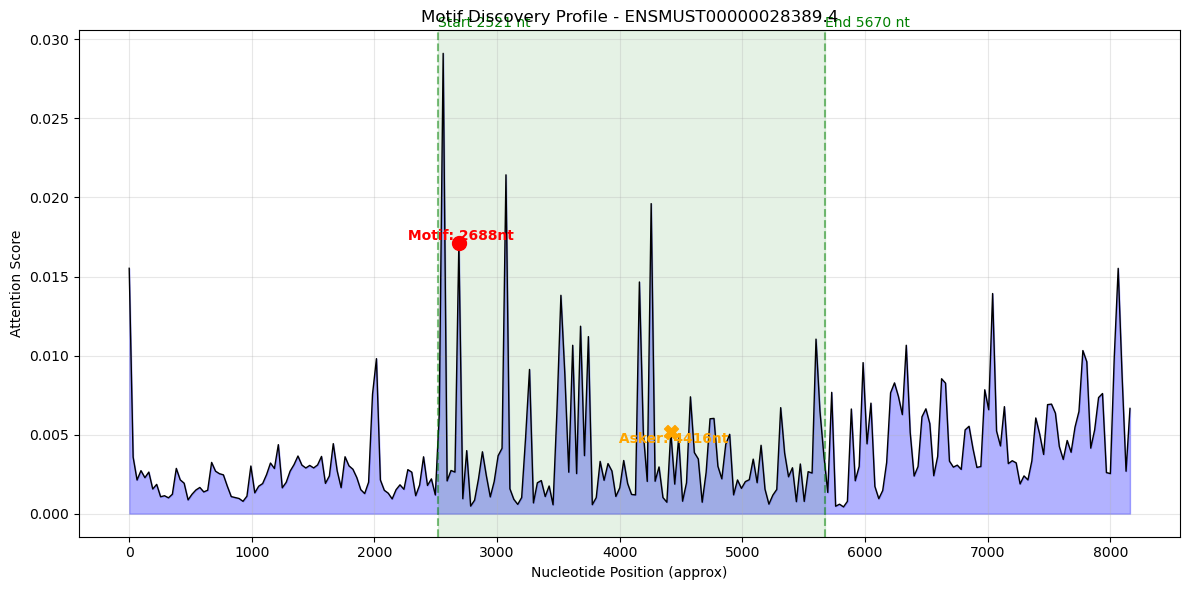

In [33]:
# CHOOSE THE TARGET TO PLOT
# target_id = df.iloc[0]["Isoforms"]
target_id = "ENSMUST00000028389.4"

target_tensor = None
for i in range(len(dataset)):
    current_id, current_tensor = dataset[i] 
    
    if str(current_id) == str(target_id):
        target_tensor = current_tensor.unsqueeze(0).to(device)
        break

# GET PLOTTING DATA
if target_tensor is not None:
    captured_maps = [] 
    _ = model(target_tensor)

    # Extract Data
    last_layer_attn = captured_maps[-1][0].cpu().numpy()
    actual_len = last_layer_attn.shape[0]
    x_axis_nucleotides = np.arange(actual_len) * compression_factor
    profile = last_layer_attn.mean(axis=0)

    # PLOT: Heatmap + Profile (Stacked)
    # ---------------------------------------------------------
    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # # Subplot: Heatmap
    # sns.heatmap(
    #     last_layer_attn, 
    #     cmap="viridis", 
    #     ax=ax1,
    #     xticklabels=32, 
    #     yticklabels=32
    # )
    # ax1.set_title(f"Attention Heatmap - {target_id}")
    # ax1.set_xlabel("Key Position (Features)")
    # ax1.set_ylabel("Query Position (Features)")
    
    # Subplot: Profile

    fig, ax2 = plt.subplots(figsize=(12,6))
    
    ax2.plot(x_axis_nucleotides, profile, color='black', linewidth=1)
    ax2.fill_between(x_axis_nucleotides, profile, alpha=0.3, color='blue')

    # Highlight sequence location
    raw_len = id_to_length.get(str(target_id), 0)
    
    if raw_len < total_len:
        pad_total = total_len - raw_len
        pad_half = pad_total // 2
        valid_start = pad_half
        valid_end = pad_half + raw_len
    else:
        valid_start = 0
        valid_end = total_len

    # Shading the valid region in light green
    ax2.axvspan(valid_start, valid_end, color='green', alpha=0.1, label='Valid RNA Region')
    
    # Adding vertical dashed lines at the boundaries
    ax2.axvline(valid_start, color='green', linestyle='--', alpha=0.5)
    ax2.axvline(valid_end, color='green', linestyle='--', alpha=0.5)
    
    # Labeling the boundaries
    ax2.text(valid_start, ax2.get_ylim()[1], f"Start {valid_start} nt", color='green', verticalalignment='bottom')
    ax2.text(valid_end, ax2.get_ylim()[1], f"End {valid_end} nt", color='green', verticalalignment='bottom')

    # Highlight asker and the motif
    flat_idx = last_layer_attn.argmax()
    query_idx, key_idx = np.unravel_index(flat_idx, last_layer_attn.shape)
    estimated_motif_nt = int(key_idx * compression_factor)
    estimated_asker_nt = int(query_idx * compression_factor)
    ax2.scatter(estimated_asker_nt, profile[query_idx], color='orange', marker='X', s=100, zorder=5, label='Asker (Query)')
    ax2.text(estimated_asker_nt, profile[query_idx], f" Asker: {estimated_asker_nt}nt", 
         color='orange', fontweight='bold', va='top', ha='center')
    
    ax2.scatter(estimated_motif_nt, profile[key_idx], color='red', s=100, zorder=5, label='Motif (Key)')
    ax2.text(estimated_motif_nt, profile[key_idx], f" Motif: {estimated_motif_nt}nt", 
         color='red', fontweight='bold', va='bottom', ha='center')

    ax2.set_title(f"Motif Discovery Profile - {target_id}")
    ax2.set_xlabel("Nucleotide Position (approx)")
    ax2.set_ylabel("Attention Score")
    ax2.grid(True, alpha=0.3)
    
    # Save to file and show
    plt.tight_layout()
    filename = "motif_result.tif"
    plt.savefig(filename)
    plt.show()

## In-silico Mutagenesis Covering the Motif (tryout)

In [16]:
df_valid = df[df['Status'] == 'Val'].copy()
df_valid.to_csv("candidates_valid.csv", index=False)

In [25]:
import random
import torch.nn.functional as F
from prediction import PredictionDataset


def mutate_sequence(seq, start_nt, length=32):
    """Replaces a specific window with random nucleotides."""
    start_nt = max(0, start_nt - length)
    seq_list = list(seq)
    bases = ['a', 'c', 'g', 't']
    end_nt = min(start_nt + 3*length, len(seq))
    for i in range(start_nt, end_nt):
        seq_list[i] = random.choice(bases)
    return "".join(seq_list)

def calculate_jsd(p_probs, q_probs):
    """Normalizes sigmoid outputs to sum to 1 and calculates JSD."""
    p = p_probs / (p_probs.sum())
    q = q_probs / (q_probs.sum())
    m = 0.5 * (p + q)
    
    # Calculate KL Divergence
    jsd = 0.5 * (F.kl_div(torch.tensor(m).log(), torch.tensor(p), reduction='batchmean').item() + 
                F.kl_div(torch.tensor(m).log(), torch.tensor(q), reduction='batchmean').item())
    return jsd
    
def get_probs(model, seq_tensor, device):
    """Replicates the manual forward pass from predict_localizations."""
    with torch.no_grad():
        seq_batch = seq_tensor.to(device)
        if seq_batch.dim() == 1:
            seq_batch = seq_batch.unsqueeze(0)
        logits = model(seq_batch, norm="layer_norm", mask=None)
        return logits[0].cpu().numpy()


def run_ism_comparison(model, original_seq, motif_nt, device):
    """Calculates JSD and Euclidean distance for multi-label predictions."""
    # Initialize helper to get the one-hot logic
    ds_helper = PredictionDataset([]) 
    max_len = 8192

    # Centered padding or sided truncating
    if len(original_seq) > max_len:
        half = max_len // 2
        manu_seq = original_seq[:half] + original_seq[-half:]
    else:
        pad_len = max_len - len(original_seq)
        l1, l2 = pad_len // 2, pad_len - (pad_len // 2)
        manu_seq = ("o" * l1) + original_seq + ("o" * l2)

    # Prepare Original
    orig_onehot = ds_helper.seq2one_hot(manu_seq)
    orig_tensor = torch.from_numpy(orig_onehot).type(torch.float).unsqueeze(0).to(device)
    # --- Prepare Mutated ---
    mut_seq = mutate_sequence(manu_seq, motif_nt, length=32)
    mut_onehot = ds_helper.seq2one_hot(mut_seq)
    mut_tensor = torch.from_numpy(mut_onehot).type(torch.float).unsqueeze(0).to(device)
    
    model.eval()

#    probs_orig = torch.sigmoid((logits_orig - B) / T).squeeze(0).detach().cpu().numpy()
#    probs_mut = torch.sigmoid((logits_mut - B) / T).squeeze(0).detach().cpu().numpy()

    probs_orig = get_probs(model, orig_tensor, device)
    probs_mut = get_probs(model, mut_tensor, device)
    # 3. Track the Shift
    jsd = calculate_jsd(probs_orig, probs_mut)
    idx_before = np.argmax(probs_orig)
    class_before = label_names[idx_before]
    idx_after = np.argmax(probs_mut)
    class_after = label_names[idx_after]
    
    # p1: Original primary change
    p1_str = f"{probs_orig[idx_before]*100:.1f}% -> {probs_mut[idx_before]*100:.1f}%"
    
    # p2: New primary change (or runner-up if same)
    target_idx2 = idx_after if idx_after != idx_before else np.argsort(probs_orig)[-2]
    p2_str = f"{probs_orig[target_idx2]*100:.1f}% -> {probs_mut[target_idx2]*100:.1f}%"

    return class_before, class_after, p1_str, p2_str, jsd

In [26]:
top_results = []
label_names = ["chromatin", "cytoplasm", "cytosol", "ER", "extracellular", 
               "membrane", "mitochondrion", "nucleolus", "nucleoplasm", "nucleus", "ribosome"]

for idx, row in df_valid.head(200).iterrows():
    seq_id = row['Isoforms']
    motif_nt = int(row['Motif Location'])
    
    # Extract the original string from the raw_data
    original_seq = next(s[1] for s in raw_data if str(s[0]) == str(seq_id))
    
    class_before, class_after, p1_str, p2_str, jsd = run_ism_comparison(model, original_seq, motif_nt, device)
    
    top_results.append({
        "Isoforms": seq_id,
        "MotifLoc": motif_nt,
        "JSD": jsd,
        "PrimaryBef": class_before,
        "Prob Shift": p1_str,
        "PrimaryAft": class_after,
        "New/Runner-up": p2_str
    })

ism_summary = pd.DataFrame(top_results)
print(f'\n "Mutation Done"')
ism_summary.to_csv("In-silico Mutagenesis.csv", index=False)


 "Mutation Done"
